In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
from dataLoaders import DataLoaders
import numpy as np
import torchvision

import matplotlib.pyplot as plt
import time
from pathlib import Path
from tqdm.notebook import trange, tqdm
from torch.utils.tensorboard import SummaryWriter
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
# from torchvision import datasets, models, transforms
import itertools
# import pixiedust
import random
from torch.utils import data
# from itertools import tee
from datetime import datetime
from utils import NET_ARCHICECTURE
from enum import Enum
from trainer import Trainer
from model import get_model

print("Torch Version: ", torch.__version__)
print("Cuda available?", torch.cuda.is_available())

Torch Version:  1.5.0
Cuda available? True


In [3]:
try:
    from google.colab import drive
    drive.mount('/content/gdrive')
    LABS_DIR = Path ('/content/gdrive/My Drive/Labs')
except:
    LABS_DIR = Path ('C:/Labs/')

#DATA_DIR = LABS_DIR/'Data'    
DATA_DIR = LABS_DIR/'DataNoDuplicates'
#DATA_DIR = LABS_DIR/ 'DataDomains_v1'
DATA_DIR_M = LABS_DIR/'DataTraining'/'Male'
DATA_DIR_F = LABS_DIR/'DataTraining'/'Female'


In [4]:
class TrainingParams:
    def __init__(self,lr_initial,step_size,gamma,weight_decay, num_epochs):
        self.lr = lr_initial
        self.step_size = step_size
        self.gamma = gamma
        self.weight_decay = weight_decay
        self.label_criterion = nn.CrossEntropyLoss()  # softmax+log
        self.domain_criterion = nn.functional.binary_cross_entropy_with_logits 
        self.num_epochs = num_epochs
#         self.model = None
        
    def __str__(self):
        return f'_lr_{self.lr}_st_{self.step_size}_gma_{self.gamma}_wDK_{self.weight_decay}'
    
    @property
    def model(self):
        return self.__model
    
    @model.setter
    def model(self, model_conv):
        self.__model = model_conv
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        self.scheduler= lr_scheduler.StepLR(self.optimizer, step_size=self.step_size, gamma=self.gamma)        
    

In [5]:
#### sanity check for the images 
# classes = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']
# for emotion in classes:
#     print("Class =",emotion)
#     !ls $DATA_DIR\VAL\$emotion | wc -l

# Data Loader

In [6]:
BATCH_SIZE = 32
SAMPLE_SIZE = 3000 

dataloader_all = DataLoaders(sample_size=SAMPLE_SIZE, batch_size=BATCH_SIZE//2, data_dir=DATA_DIR, val_same_as_train=False)
dataloder_male = DataLoaders(sample_size=None, batch_size=BATCH_SIZE//2, data_dir=DATA_DIR_M, val_same_as_train=False)
dataloder_female = DataLoaders(sample_size=None, batch_size=BATCH_SIZE//2, data_dir=DATA_DIR_F, val_same_as_train=False)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device: ", device)
print("Classes: ", dataloder_male.classes) 
print(f'Male Train image size: {dataloder_male.dataset_size["train"]}')
print(f'Male Validation image size: {dataloder_male.dataset_size["val"]}')
print(f'Female Train image size: {dataloder_female.dataset_size["train"]}')
print(f'Female Validation image size: {dataloder_female.dataset_size["val"]}')

device:  cuda:0
Classes:  ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']
Male Train image size: 2819
Male Validation image size: 707
Female Train image size: 2954
Female Validation image size: 742


In [7]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated  


# Show sample of the data for review


classes=tensor([2, 1, 2, 5, 0, 6, 0, 0, 4, 4, 6, 0, 2, 0, 6, 2])


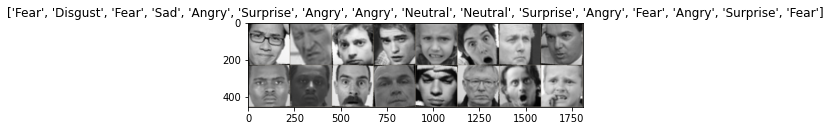

classes=tensor([0, 1, 5, 4, 2, 3, 0, 3, 1, 4, 4, 5, 6, 0, 4, 3])


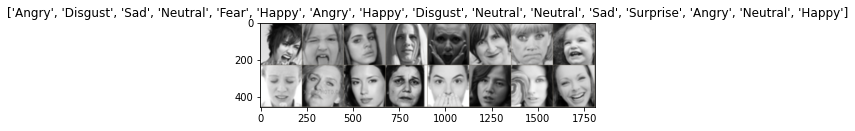

In [8]:
# # Get a batch of training data
class_names = dataloder_female.classes

inputs, classes = next(iter(dataloder_male.data['train']))
print()
# Make a grid from batch
sample_train_images = torchvision.utils.make_grid(inputs)
#imshow(sample_train_images, title=classes)
print(f"classes={classes}")
imshow(sample_train_images, title=[class_names[i] for i in classes])


# # Get a batch of validation data
inputs, classes = next(iter(dataloder_female.data['val']))
# Make a grid from batch
sample_train_images = torchvision.utils.make_grid(inputs)
#imshow(sample_train_images, title=classes)
print(f"classes={classes}")
imshow(sample_train_images, title=[class_names[i] for i in classes])

# Train Model

In [9]:
# CHECK_POINT_PATH = LABS_DIR/'ModelParams'/'checkpoint.tar'

# # !del $CHECK_POINT_PATH

# try:
#     checkpoint = torch.load(CHECK_POINT_PATH)
#     print("checkpoint loaded")
# except:
#     checkpoint = None
#     print("checkpoint not found")

In [10]:
NUM_EPOCHS = 30

def run_experiment(use_discriminator, experiment_title, domain1_dataloader,domain2_dataloader, test_dataloaders, training_params, architecure : NET_ARCHICECTURE):
    """
    Gets all hyper parameters and creates the relevant optimizer and scheduler according to those params

    """

    training_params.model = get_model(device,domain1_dataloader.classes, architecure)
    
    descriminator_description = "D" if use_discriminator else "ND"
    experiment_name = datetime.now().strftime("%Y%m%d-%H%M%S") + "_"+ descriminator_description + str(training_params)
    print("Starting, experiment name: ", experiment_name)

    writer = SummaryWriter('runs/' + experiment_name)
    trainer = Trainer(device, domain1_dataloader, domain2_dataloader, BATCH_SIZE)
    
    trained_params_model = trainer.train_model(use_discriminator, training_params, writer=writer)
    
    print(f"Experiment {experiment_name} - testing on the women domain")
    test_acc = {experiment_title+loader_title : trainer.test(test_loader,trained_params_model) for loader_title,test_loader in test_dataloaders.items()}
    return trained_params_model, test_acc


# for lr in [0.001, 0.0005, 0.0001]:
#     for scheduler_step_size in [7]:
#         for scheduler_gamma in [0.3, 0.5]:
#             for weight_decay in [0.01,0.05,0.1]:
#                 model_conv = run_experiment(dataloder_male,dataloder_female, lr, scheduler_gamma, scheduler_step_size, weight_decay, NUM_EPOCHS,'fc_20+50_DO')


# trained_model_and_params = run_experiment(dropout_layer=NET_ARCHICECTURE.TWO_FC, domain1_dataloader=dataloder_male,domain2_dataloader=dataloder_female, lr_initial=0.0001, gamma=0.5, step_size=7, weight_decay=0.01 , num_of_epochs=10,experiment_note='final_tuning')
training_params = TrainingParams(lr_initial=0.0001,step_size=7,gamma=0.5,weight_decay=0.01, num_epochs=NUM_EPOCHS)

# trained_model_and_params = run_experiment(use_discriminator=False, \
#                                           domain1_dataloader=dataloader_all,domain2_dataloader=dataloader_all, test_dataloader = dataloader_all,\
#                                           training_params,experiment_note='no_discriminator')
""" Train on both genders w\o discriminator and test spretley on the genders"""

arch = NET_ARCHICECTURE.ONE_FC
test_loaders = {"M" : dataloder_male,
                "F" : dataloder_female}

print("1st case: Train on both genders w\o discriminator and test separately on the genders")
_,p1 = run_experiment(use_discriminator=False, experiment_title = "p1",\
                       domain1_dataloader=dataloader_all,domain2_dataloader=dataloader_all,\
                       test_dataloaders = test_loaders,training_params=training_params, architecure=arch)
print(p1)
print("Finished -----------------\r\n\r\n")

print("2nd case: Train on one gender w\o discriminator and test separately on the genders")
_,p2 = run_experiment(use_discriminator=False, experiment_title = "p2", \
                       domain1_dataloader=dataloder_male,domain2_dataloader=dataloder_female, \
                       test_dataloaders = test_loaders,training_params=training_params,architecure=arch)
print(p2)
print("Finished -----------------\r\n\r\n")

print("3rd case: Train on one gender with discriminator and test separately on the genders")
_,p3 = run_experiment(use_discriminator=True, experiment_title = "p3", \
                       domain1_dataloader=dataloder_male,domain2_dataloader=dataloder_female, \
                       test_dataloaders = test_loaders,training_params=training_params,architecure=arch)
print(p3)
print("Finished -----------------\r\n\r\n")
# print(f"p1(M): {p1M} p1(F): {p1F}")
# print(f"p2(M): {p2M} p2(F): {p2F}")
# print(f"p3(M): {p3M} p3(F): {p3F}")

# print(f"p1(M): {p1M} p1(F): {p1F} p2(M): {p2M} p2(F): {p2F} p3(M): {p3M} p3(F): {p3F}")
# trained_model_and_params, test_acc = run_experiment(use_discriminator=False, \
#                                           domain1_dataloader=dataloder_male,domain2_dataloader=dataloder_male, test_dataloader = dataloder_male,training_params=training_params)

# trained_model_and_params = run_experiment(dropout_layer=NET_ARCHICECTURE.TWO_FC, domain1_dataloader=dataloder_male,domain2_dataloader=dataloder_female, lr_initial=0.0001, gamma=0.5, step_size=7, weight_decay=0.01 , num_of_epochs=NUM_EPOCHS,experiment_note='final_tuning')
# trained_model_and_params = run_experiment(dropout_layer=NET_ARCHICECTURE.NO_FC, domain1_dataloader=dataloder_male,domain2_dataloader=dataloder_female, lr_initial=0.0001, gamma=0.5, step_size=7, weight_decay=0.1, num_of_epochs=NUM_EPOCHS,experiment_note='final_tuning')
# trained_model_and_params = run_experiment(dropout_layer=NET_ARCHICECTURE.ONE_FC, domain1_dataloader=dataloder_male,domain2_dataloader=dataloder_female, lr_initial=0.0001, gamma=0.5, step_size=7, weight_decay=0.1, num_of_epochs=NUM_EPOCHS,experiment_note='final_tuning')


1st case: Train on both genders w\o discriminator and test separately on the genders
Starting, experiment name:  20210111-234725_ND_lr_0.0001_st_7_gma_0.5_wDK_0.01
Starting epochs
Epoch: 1 of 30
Test Loss: 1.3160 TestAcc: 0.5073
Epoch: 2 of 30
Test Loss: 1.2312 TestAcc: 0.5487
Epoch: 3 of 30
Test Loss: 1.3234 TestAcc: 0.5353
Epoch: 4 of 30
Test Loss: 1.3698 TestAcc: 0.5567
Epoch: 5 of 30
Test Loss: 1.5618 TestAcc: 0.5260
Epoch: 6 of 30
Test Loss: 1.4912 TestAcc: 0.5343
Epoch: 7 of 30
Test Loss: 1.7018 TestAcc: 0.5237
Epoch: 8 of 30
Test Loss: 1.6094 TestAcc: 0.5700
Epoch: 9 of 30
Test Loss: 1.6675 TestAcc: 0.5500
Epoch: 10 of 30
Test Loss: 1.6929 TestAcc: 0.5730
Epoch: 11 of 30
Test Loss: 1.6972 TestAcc: 0.5617
Epoch: 12 of 30
Test Loss: 1.7771 TestAcc: 0.5507
Epoch: 13 of 30
Test Loss: 1.8165 TestAcc: 0.5467
Epoch: 14 of 30
Test Loss: 1.8459 TestAcc: 0.5323
Epoch: 15 of 30
Test Loss: 1.7435 TestAcc: 0.5730
Epoch: 16 of 30
Test Loss: 1.7032 TestAcc: 0.5763
Epoch: 17 of 30
Test Loss: 1.

In [11]:
# torch.save({'model_state_dict': model_conv.state_dict(),
#             'optimizer_state_dict': optimizer_conv.state_dict(),
#             'best_val_loss': best_val_loss,
#             'best_val_accuracy': best_val_acc,
#             'scheduler_state_dict' : exp_lr_scheduler.state_dict(),
#             }, CHECK_POINT_PATH)

# Test Model